# Natural Language Processing Demystified | Classification with Naive Bayes
https://nlpdemystified.org<br>
https://github.com/futuremojo/nlp-demystified
<br><br>
Course module for this demo: https://www.nlpdemystified.org/course/naive-bayes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

/home/james/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# First pass at building a Naive Bayes model.


As with our TF-IDF demo, we'll use the topic modelling file we have performed in the previous class.

In [2]:
import pandas as pd
training_corpus = pd.read_excel('topics.xlsx').dropna()

In [3]:
print('Training data size: {}'.format(len(training_corpus)))

Training data size: 6228


The training data we downloaded not only includes the posts but also a label ("target") for each post representing its topic. In our case, it will be the column 'labels' of our dataset.

In [4]:
# These are the labels/targets for each post.
print(training_corpus['labels'])

0       0
1       3
2       2
3       5
4       9
       ..
7345    0
7346    0
7347    7
7348    9
7349    0
Name: labels, Length: 6228, dtype: int64


In [5]:
# The first post along with its corresponding label.
print(training_corpus['abstract'][0])

first_doc_label = training_corpus['labels'][0]
print('Corresponding topic: {}'.format(training_corpus['labels'][first_doc_label]))

High-entropy alloys have attracted extensive attention due to their new design concept and excellent performance. As a kind of high-entropy alloy, refractory high-entropy alloys are mainly composed of bcc crystal structure, which has the characteristics of high strength and high hardness as well as the high temperature softening resistance. In the present paper, the preparation method, phase structure, microstructure, mechanical properties and application fields of refractory high-entropy alloy were described, and the directions of future research were also discussed.
Corresponding topic: 0


When starting off with a dataset, it's a good idea to check its distribution. In this case, we can see at a glance this dataset is relatively balanced.

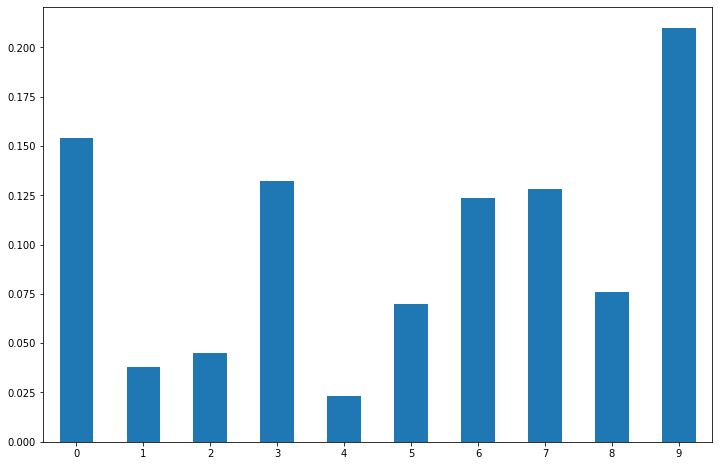

In [6]:
bins, counts = np.unique(training_corpus['labels'], return_counts=True)
freq_series = pd.Series(counts/len(training_corpus['abstract']))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

Now that we have our training set, we can split it further into train and validation sets. If you have a small training set like this one, you can use alternative techniques like cross-validation but we'll show a split here since we talked about it in the model building module. scikit-learn has a module to help us do this.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [7]:
# Shuffle, then split the data into train and validation sets. Set the random_state
# to 1 for reproducibility.
train_data, val_data, train_labels, val_labels = train_test_split(training_corpus['abstract'], training_corpus['labels'], train_size=0.8, random_state=1)
print('Training data size: {}'.format(len(train_data)))
print('Validation data size: {}'.format(len(val_data)))

Training data size: 4982
Validation data size: 1246


Now that we have our train-validation split, let's create our spaCy tokenizer. Up to this point, we've been using the **en_core_web_sm** model.

In [8]:
nlp = spacy.load('en_core_web_sm')

By default, it comes up with a preprocessing pipeline with several components enabled. We can view these components through the *pipe_names* attribute.

In [9]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In the previous demos, we individually disabled any component we didn't need. For our first pass at building a Naive Bayes classifier, we'll try tokenizing alone. Nothing else. Since that's the case, it's easier to instantiate a blank pipeline.<br>
https://spacy.io/api/top-level#spacy.blank

In [10]:
nlp = spacy.blank('en')

# There should be no pipeline components.
nlp.pipe_names

[]

In [23]:
# For this exercise, we'll remove punctuation and spaces (which
# includes newlines), filter for tokens consisting of alphabetic
# characters only, and return the token text.
nlp.Defaults.stop_words.add("nan")

def spacy_tokenizer(doc):
  return [t.text for t in nlp(doc) if \
          not t.is_punct and \
          not t.is_space]

We'll vectorize using the **TfidfVectorizer**.

In [24]:
%%time
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

CPU times: user 2min 39s, sys: 24.4 ms, total: 2min 39s
Wall time: 2min 39s


Scikit-learn includes a multinomial naive bayes classifier.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Calling *fit* on the classifier and passing it the feature vectors and corresponding labels kicks off the training.

In [25]:
# Instantiate a classifier with the default settings.
nb_classifier = MultinomialNB()
nb_classifier.fit(train_feature_vects, train_labels)
nb_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

Now that we know about the **F1 score** and have a multiclass problem, let's look at the F1 score on the training data. Since the dataset is balanced, accuracy could work here as well but we'll look at F1 since we introduced it. scikit-learn has a module called **metrics** we can leverage. It contains a variety of scoring utilities we can use.<br>
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score<br>
https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics<br>

In [26]:
# Get predictions on training set and calculate F1 score.
# See documentation above for more details on what "macro" means.
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on initial training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

F1 score on initial training set: 0.44126800359254437


So right off the bat, using simple preprocessing and vectorization, and the default settings on the Naive Bayes classifier, we get a model with a decent F1 score.<br><br>

Let's plot a confusion matrix to see what's going on:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html<br>
https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

In [27]:
# Vectorize the validation data.
val_feature_vects = vectorizer.transform(val_data)

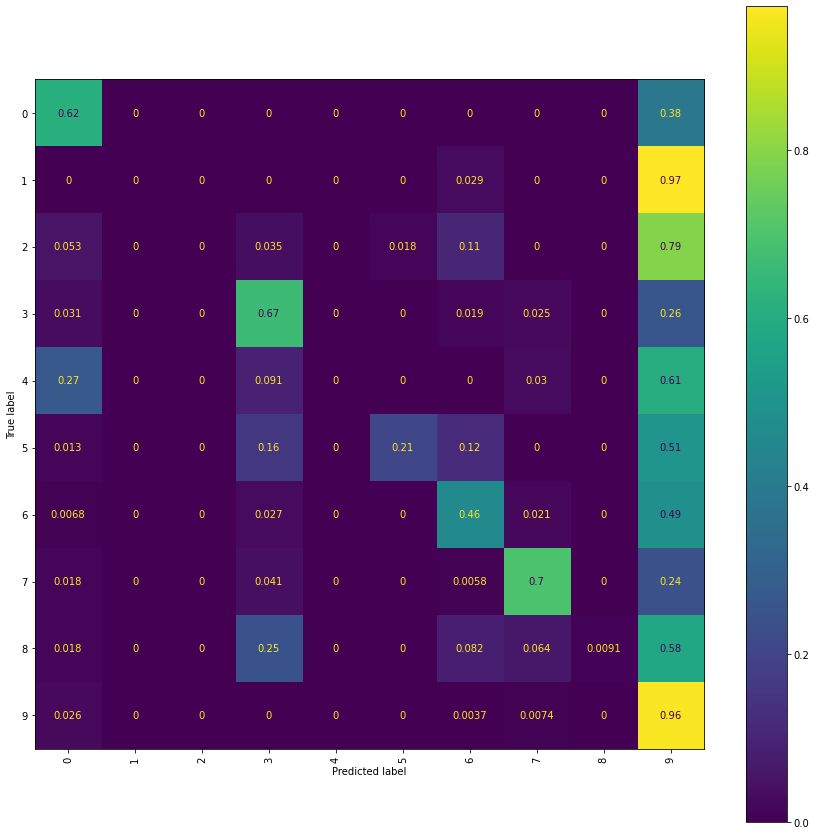

In [28]:
# Set the size of the plot.
fig, ax = plt.subplots(figsize=(15, 15))

# Create the confusion matrix.
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', xticks_rotation='vertical', ax=ax)
# If you had an error, upgrade your scikit-learn package.
# pip uninstall scikit-learn
# pip install scikit-learn==1.0.2

Similar to what we saw in the slides, the y-axis represents the true labels and the x-axis represents the predictions. Each square's brightness represents the number of posts assigned to that class. What we ideally want is brightness along the diagonal (top-left to bottom-right) which represent correct predictions, and little to no brightness anywhere else.
<br><br>

Let's take a look at **precision** and **recall** for each label:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html<br>
https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report

The next celll is just to be aligned with the original tutorial and avoid a lot of rewrites.

In [29]:
# Predict and evaluate.
val_preds = nb_classifier.predict(val_feature_vects)
print('F1 score on filtered validation set: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

F1 score on filtered validation set: 0.35850506697111484


In [30]:
print(metrics.classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.79      0.62      0.69       188
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        57
           3       0.66      0.67      0.66       159
           4       0.00      0.00      0.00        33
           5       0.94      0.21      0.34        77
           6       0.69      0.46      0.55       146
           7       0.88      0.70      0.78       171
           8       1.00      0.01      0.02       110
           9       0.38      0.96      0.54       271

    accuracy                           0.55      1246
   macro avg       0.53      0.36      0.36      1246
weighted avg       0.63      0.55      0.50      1246



/home/james/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/james/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/james/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Improving the model



Let's try to do better. One thing that's likely an issue is the sheer number of features we have relative to how little data there is.

In [31]:
print('Training data size: {}'.format(len(train_data)))
print('Number of training features: {}'.format(len(train_feature_vects[0].toarray().flatten())))

Training data size: 4982
Number of training features: 23507


So we can experiment with:
1. Removing stop words because topic identification likely depends more on keywords rather than sequences in this case.
3. Using the token lemma rather than the text.
<br>


We can't get away with the blank pipeline since we need a bunch of components to generate the lemma. So we'll load the **en_core_web_sm** model and disable named-entity recognition and parsing in the tokenizer callback.

In [32]:
nlp = spacy.load('en_core_web_sm')

In [33]:
unwanted_pipes = ['ner', 'parser']

# Further remove stop words and take the lemma instead of token text.
def spacy_tokenizer(doc):
  with nlp.disable_pipes(*unwanted_pipes):
    return [t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop]

We need to re-vectorize the training set with the new tokenizer. Because there are certain components enabled, this is going to take longer (a few mins). Take a look at these link for ways to further optimize spaCy's pipeline:<br>
https://spacy.io/usage/processing-pipelines#processing<br>
https://spacy.io/api/language#pipe<br><br>
YouTube video from spaCy on using **nlp.pipe**: [Speed up spaCy pipelines via `nlp.pipe` - spaCy shorts](https://www.youtube.com/watch?v=OoZ-H_8vRnc)<br>
Tuning **nlp.pipe**: https://stackoverflow.com/questions/65850018/processing-text-with-spacy-nlp-pipe<br>
Passing a list of pre-processed tokens to TfidfVectorizer: https://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/

In [34]:
%%time
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

CPU times: user 1min 18s, sys: 31.9 ms, total: 1min 18s
Wall time: 1min 18s


In [35]:
# Check the number of features now.
print('Number of training features: {}'.format(len(train_feature_vects[0].toarray().flatten())))

Number of training features: 20660


A little better but still not great. Let's retrain our classifier and see what happens.

In [36]:
nb_classifier.fit(train_feature_vects, train_labels)
train_preds = nb_classifier.predict(train_feature_vects)
print('Training F1 score with fewer features: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

Training F1 score with fewer features: 0.5102835636890866


Check classifier performance on validation set.

In [37]:
%%time
val_feature_vects = vectorizer.transform(val_data)

CPU times: user 19.3 s, sys: 16 ms, total: 19.3 s
Wall time: 19.4 s


In [38]:
val_preds = nb_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.41080931328902104


Let's look at the confusion matrix and classification report.

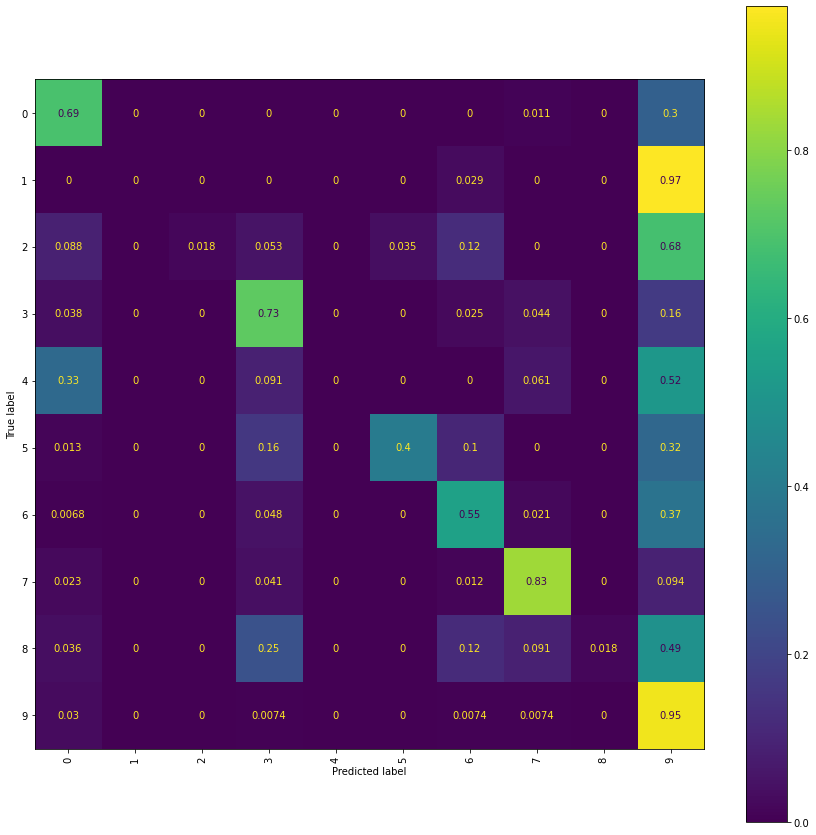

In [39]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', xticks_rotation='vertical', ax=ax)

In [41]:
print(metrics.classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.76      0.69      0.73       188
           1       0.00      0.00      0.00        34
           2       1.00      0.02      0.03        57
           3       0.66      0.73      0.69       159
           4       0.00      0.00      0.00        33
           5       0.94      0.40      0.56        77
           6       0.69      0.55      0.61       146
           7       0.85      0.83      0.84       171
           8       1.00      0.02      0.04       110
           9       0.45      0.95      0.61       271

    accuracy                           0.61      1246
   macro avg       0.63      0.42      0.41      1246
weighted avg       0.68      0.61      0.56      1246



/home/james/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/james/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/james/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's assume for now that we can't get or generate more data.

Next, we can try tuning a hyperparameter on the classifier. For Naive Bayes, we'll adjust the the *alpha* smoothing factor we discussed in the slides. But rather than trying a bunch ourselves, we can use a combination of **Grid Search** and **Cross Validation**.
- Grid search involves having the computer try a list of hyperparameter values for us, and returning the best performing value. The list of hyperparameter values to try is supplied by us. Grid search is a basic technique and there are a number of other techniques such as **random search** and **bayesian optimization**.
- Cross validation is a way to evaluate machine learning models on limited datasets. It randomly splits the data into k-groups. One group is set aside as the holdout set while the classifier trains a model on the remaining groups. The resulting model is then used on the holdout group and the score recorded. This repeats itself until all groups have been used as a holdout set and an average score returned.

Scikit-learn has modules to handle both for us:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html<br>
https://scikit-learn.org/stable/modules/grid_search.html#grid-search<br>
https://scikit-learn.org/stable/modules/cross_validation.html<br>


In [42]:
# The alpha values to try.
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0,],}

# Instantiate the search with the model we want to try and fit it on the training data.
multinomial_nb_grid = model_selection.GridSearchCV(MultinomialNB(), param_grid=params, scoring='f1_macro', n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(train_feature_vects, train_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]},
             scoring='f1_macro', verbose=5)

The resulting **GridSearchCV** object has a number of attributes you can explore:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
<br><br>
We're interested in the best performing parameter value(s).

In [43]:
print('Best parameter value(s): {}'.format(multinomial_nb_grid.best_params_))

Best parameter value(s): {'alpha': 0.01}


You can directly access the best estimator found by the search. Let's try using it on the validation set.

In [44]:
best_nb_classifier = multinomial_nb_grid.best_estimator_
val_preds = best_nb_classifier.predict(val_feature_vects)
print('Validation F1 score with fewer features: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

Validation F1 score with fewer features: 0.6838846449176154


So we got another decent jump after using the the optimal *alpha* value. Let's look at the confusion matrix (using the best estimator so far) and classification report again.


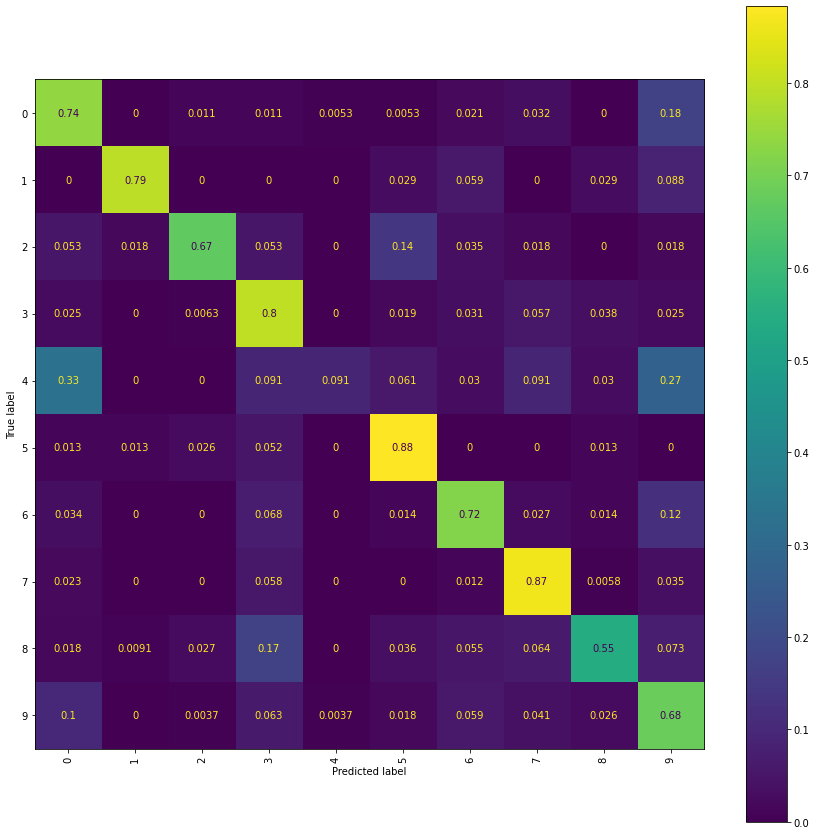

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_estimator(best_nb_classifier, val_feature_vects, val_labels, normalize='true', xticks_rotation='vertical', ax=ax)

In [46]:
print(metrics.classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72       188
           1       0.90      0.79      0.84        34
           2       0.81      0.67      0.73        57
           3       0.65      0.80      0.72       159
           4       0.60      0.09      0.16        33
           5       0.72      0.88      0.80        77
           6       0.73      0.72      0.73       146
           7       0.78      0.87      0.82       171
           8       0.76      0.55      0.63       110
           9       0.69      0.68      0.69       271

    accuracy                           0.72      1246
   macro avg       0.74      0.68      0.68      1246
weighted avg       0.72      0.72      0.71      1246



Given the small data size and the soft borders around various topics, what we have now is probably good enough. A few further ideas to explore:
1. Augment the training data with posts from similar subreddits.
2. Incorporate n-grams.
3. Remove the *misc* categories if your goal allows it.
4. Merge a few categories with large overlap together if your goal allows it.
5. Use the **CountVectorizer** instead of the **TfidfVectorizer**.
6. Play around with adding more stop words after seeing which ones are the most prevalent.
7. Play with the min_df, max_df, and max_features in the **TFidfVectorizer**.
8. Use a dimensionality reduction technique like Singular Value Decomposition (SVD) or dense word vectors which we'll cover in Part II.
9. Try other models: logistic regression, support vector machines, random forests, SGD classifier.

My guess is that, aside from merging categories, it'll be hard to do much better than what we have given the nature of the data.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
<br>
https://scikit-learn.org/stable/modules/svm.html#svm-classification
<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html



For idea **(6)**, we can use the function below to view the most commonly occurring words in each category.

In [47]:
def show_top_words(classifier, vectorizer, categories, top_n):
  feature_names = np.asarray(vectorizer.get_feature_names_out())
  for i, category in enumerate(categories):
    prob_sorted = classifier.feature_log_prob_[i, :].argsort()[::-1]
    print("%s: %s" % (category, " ".join(feature_names[prob_sorted[:top_n]])))

In [48]:
show_top_words(best_nb_classifier, vectorizer, np.sort(training_corpus['labels'].unique()), 10)

0: alloy high material heas property entropy hea design phase new
1: film coating thin deposit nitride structure gpa sputter magnetron substrate
2: corrosion resistance alloy film passive electrochemical coating solution hea high
3: strength hea alloy powder high grain composite mpa phase mechanical
4: material reaction catalyst surface alloy metal new activity high steel
5: coating wear resistance substrate hea laser high phase hardness alloy
6: phase alloy bcc fcc x = content al structure high
7: deformation dislocation strain grain twin temperature stress high strength alloy
8: degree c temperature phase alloy oxidation anneal high c. 800
9: alloy high phase ni entropy hea cr temperature energy fe


As a sanity check, we can use scikit-learns **DummyClassifier** which can make predictions using strategies such as "just guess the most frequently occurring class" or "make random guesses".<br>
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [49]:
# Train a dummy classifier which just guesses the most frequent class.
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_feature_vects, train_labels)
dummy_clf.score(val_feature_vects, val_labels)

0.2174959871589085

In [50]:
# Train a dummy classifier which just guesses a class randomly.
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(train_feature_vects, train_labels)
dummy_clf.score(val_feature_vects, val_labels)

0.09229534510433386

We can see the dummy classifier is much worse.

# Creating the final Naive Bayes classifier.

Let's train the classifier we'll use on the test set. We'll use the entire original training set (including validation data) and the ideal *alpha* param.
<br>
We'll also use scikit-learn's **Pipeline** to specify a series of transformation and training steps so we can vectorize and fit a model with one call. Creating a few of these pipelines can help speed up your development and stay organized:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html


In [51]:
text_classifier = Pipeline([
  ('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
  ('classifier', MultinomialNB(alpha=0.01))
])

In [52]:
%%time
text_classifier.fit(training_corpus['docs'], training_corpus['labels'])

CPU times: user 22.7 s, sys: 36 ms, total: 22.7 s
Wall time: 22.8 s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f5481d898c0>)),
                ('classifier', MultinomialNB(alpha=0.01))])

In [53]:
filtered_test_corpus = training_corpus

We can now pass the raw test data directly to the classifier.

In [54]:
%%time
test_preds = text_classifier.predict(filtered_test_corpus['docs'])

CPU times: user 21.8 s, sys: 20.2 ms, total: 21.9 s
Wall time: 22.1 s


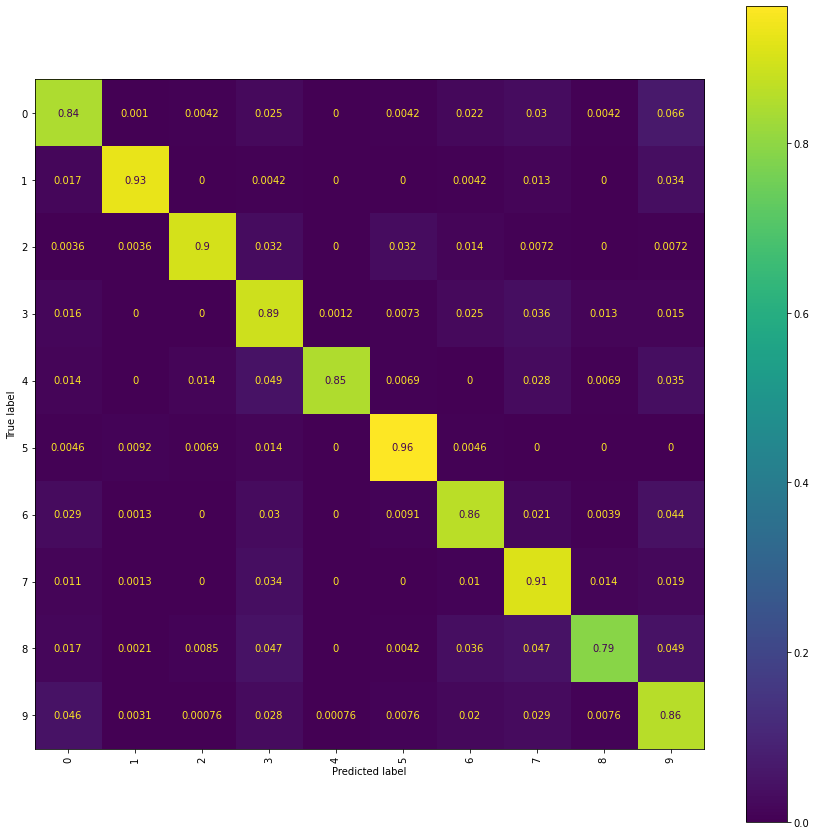

CPU times: user 594 ms, sys: 75.9 ms, total: 670 ms
Wall time: 519 ms


In [55]:
%%time
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(filtered_test_corpus['labels'], test_preds, normalize='true', xticks_rotation='vertical', ax=ax)
plt.show()

We can see now that our model is working very well!
<br><br>

In [56]:
print(metrics.classification_report(filtered_test_corpus['labels'], test_preds))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       958
           1       0.94      0.93      0.94       236
           2       0.95      0.90      0.92       279
           3       0.83      0.89      0.85       825
           4       0.98      0.85      0.91       144
           5       0.91      0.96      0.94       436
           6       0.87      0.86      0.87       771
           7       0.83      0.91      0.87       798
           8       0.90      0.79      0.84       473
           9       0.87      0.86      0.87      1308

    accuracy                           0.87      6228
   macro avg       0.90      0.88      0.89      6228
weighted avg       0.87      0.87      0.87      6228



We can now leverage our pipeline to classify new documents on the fly now.
<br><br>
The function below takes a classifier, a document to classify, and an optional set of labels. It returns a tuple of the most probable class and its probability. With this information, you can choose a probability threshold over which to accept a classification. If it falls below the threshold, perhaps you can classify it in some default bucket or pass it to a human, or to another classifier downstream. You could also require a minimum string length for classification along with other conditions.
<br><br>


In [62]:
def classify_text(clf, doc, labels=None):
  probas = clf.predict_proba([doc]).flatten()
  max_proba_idx = np.argmax(probas)

  if labels:
    most_proba_class = labels[max_proba_idx]
  else:
    most_proba_class = max_proba_idx

  return (most_proba_class, probas[max_proba_idx])

The strings below were taken at random from subreddits that have corresponding topics (e.g. r/space, r/cars, etc).

In [75]:
labels = sorted(filtered_test_corpus['labels'].unique())

In [80]:
s = "In this study, an AlCoCrFeNi high-entropy alloy (HEA) coating was fabricated by HVOF spraying process. The HEA coating was consisted of the BCC phase (Al-rich phase) and FCC phase (Al-poor phase). The BCC phase was main phase. The mechanical performances and corrosion resistances of the coating and 06Cr13Ni5Mo martensitic stainless steel were analyzed in detail. The cavitation erosion behaviors and mechanisms of the HEA coating and 06Cr13Ni5Mo steel were investigated in distilled water and 3.5 wt% NaCl solution. The effects of microstructures, mechanical properties and corrosion properties on cavitation erosion mechanisms were discussed through the observation of eroded surface morphologies. The results showed that the cavitation erosion resistance of the AlCoCrFeNi coating was about 3.5 times that of the 06Cr13Ni5Mo steel in both solutions. In the 3.5 wt% NaCl solution, corrosion damage aggravated cavitation erosion damage, although the enhancement effect of corrosion on cavitation was limited. The corrosion environment did not change the cavitation erosion mechanisms of the two materials. The cavitation erosion mechanism of the HEA coating was lamellar spalling caused by the extension of the interlaminar cracks. Due to the lower plastic deformation resistance, the cavitation erosion mechanism of the 06Cr13Ni5Mo steel was material spalling caused by plastic deformation and fatigue fracture."
classify_text(text_classifier, s, labels)

(2, 0.7942583318959885)

In [79]:
s = "Computational investigations of structural, chemical, and deformation behavior in high-entropy alloys (HEAs), which possess notable mechanical strength, have been limited due to the absence of applicable force fields. To extend investigations, we propose a set of intermolecular potential parameters for a quinary Al-Cr-Co-Fe-Ni alloy, using the available ternary Embedded Atom Method and LennardJones potential in classical molecular-dynamics simulations. The simulation results are validated by a comparison to first-principles Korringa-Kohn-Rostoker (KKR) - Coherent Potential Approximation (CPA) [KKR-CPA] calculations for the HEA structural properties (lattice constants and bulk moduli), relative stability, pair probabilities, and high-temperature short-range ordering. The simulation (MD)-derived properties are in quantitative agreement with KKR-CPA calculations (first-principles) and experiments. We study AlxCrCoFeNi for Al ranging from 0 <= x <= 2 mole fractions, and find that the HEA shows large chemical clustering over a wide temperature range for x < 0.5. At various temperatures high-strain compression promotes atomistic rearrangements in Al0.1CrCoFeNi, resulting in a clustering-to-ordering transition that is absent for tensile loading. Large fluctuations under stress, and at higher temperatures, are attributed to the thermo-plastic instability in Al0.1CrCoFeNi."
classify_text(text_classifier, s, labels)

(9, 0.9981913560987989)

In [82]:
s = "In this paper, to improve the hardness and wear resistance, AlCoCrFeNiSi HEA coatings were synthesized on AISI 304 stainless steel by laser cladding. The microstructure, chemical composition, constituent phases, microhardness, wear resistance and corrosion resistance of the coating were analyzed by scanning electron microscopy (SEM), energy-dispersive spectrometer (EDS), x-ray diffraction (XRD), Vickers microhardness tester, pin-on-disk tribological tester and electrochemical workstation, respectively. The experimental results showed that the coating possessed a single body-centered cubic (BCC) phase structure (Fe-Cr). Si element was dissolved into Fe-Cr solid solution, resulting in severe lattice distortion. The dislocation density of the coating was as high as 1.07x10(14) m(-2). Therefore, the microhardness (630.36 HV0.3) of the HEA coating was significantly improved by the effect of solid solution strengthening and dislocation strengthening. The coating exhibited excellent wear resistance, and abrasive wear was effectively avoided. The wear mechanism of the coating involved mainly oxidation wear and slight adhesion wear. The corrosion resistance of the coating was better than that of AISI 304 stainless steel in 3.5% NaCl solution. In conclusion, the AlCoCrFeNiSi HEA coating prepared by laser cladding can provide excellent wear protection to stainless steel at no expense to its own corrosion resistance."
classify_text(text_classifier, s, labels)

(5, 0.5253704583244228)

In [83]:
s = "This study investigates the effects of niobium and molybdenum on FeCoNi alloy, including on the microstructures and hardness of FeCoNiNb0.5Mo0.5 and FeCoNiNb alloys, and the polarization behaviors of these alloys in 1 M sulfuric acid and 1 M sodium chloride solutions. The results in this study indicate that both FeCoNiNb0.5Mo0.5 and FeCoNiNb alloys had a dual-phased dendritic microstructure; all of the phases in these alloys were solid solution phases, and no ordering was observed. Therefore, the solid solution effect significantly increased the hardness of these two alloys; in particular, FeCoNiNb alloy had the highest hardness of the alloys of interest. The corrosion resistance of FeCoNiNb0.5Mo0.5 and FeCoNiNb alloys was less than that of FeCoNi alloy because of their dual-phased dendritic microstructures. The corrosion resistance of the FeCoNiNb0.5Mo0.5 alloy exceeded that of the FeCoNiNb alloy in these solutions. However, FeCoNiNb0.5Mo0.5 and FeCoNiNb alloys exhibited a favorable combination of corrosion resistance and hardness."
classify_text(text_classifier, s, labels)

(2, 0.9959418452423825)

Let's classify some titles and see what happens.

In [84]:
s = "Microstructures, Hardness and Corrosion Behaviors of FeCoNiNb0.5Mo0.5 and FeCoNiNb High-Entropy Alloys"
classify_text(text_classifier, s, labels)

(2, 0.980014016216575)

Interesting, was suposed to be 2 indeed.

In [85]:
s = "Superior high-temperature properties and deformation-induced planar faults in a novel L1(2)-strengthened high-entropy alloy"
classify_text(text_classifier, s, labels)

(8, 0.6511819756516682)

Again good, was suposed to be 8.

In [86]:
s = "Microstructural evolution and wear performance of the high-entropy FeMnCoCr alloy/TiC/CaF2 self-lubricating composite coatings on copper prepared by laser cladding for continuous casting mold"
classify_text(text_classifier, s, labels)

(5, 0.9951995762170244)

Correct again :D

In [87]:
s = "Quantification of Solid Solution Strengthening and Internal Stresses through Creep Testing of Ni-Containing Single Crystals at 980 degrees C"
classify_text(text_classifier, s, labels)

(6, 0.7122585721531103)

This is correct again!<br>
The titles were never feed to the model, so we seem to have a good classifier.

**Note:**<br>
Keep in mind that Naive Bayes is good at returning the most probable class but is regarded as a poor estimator because of its naive assumption of independence (i.e. the actual probability values aren't very reliable).